# Example: JUSTICE-MATTER - IAM Simulation Run

In [1]:
import pandas as pd
import numpy as np

from src.util.data_loader import DataLoader
from src.util.enumerations import *
from src.util.model_time import TimeHorizon

## Setting Recycling Rate

JUSTICE-MATTER allows for a third policy lever: Recyling Rate. To run the simulation version of the model, we need to feed the policy levers with values we want to test. The ranges of the policy levers are from 0 to 1.0 corresponding to 0% to 100%

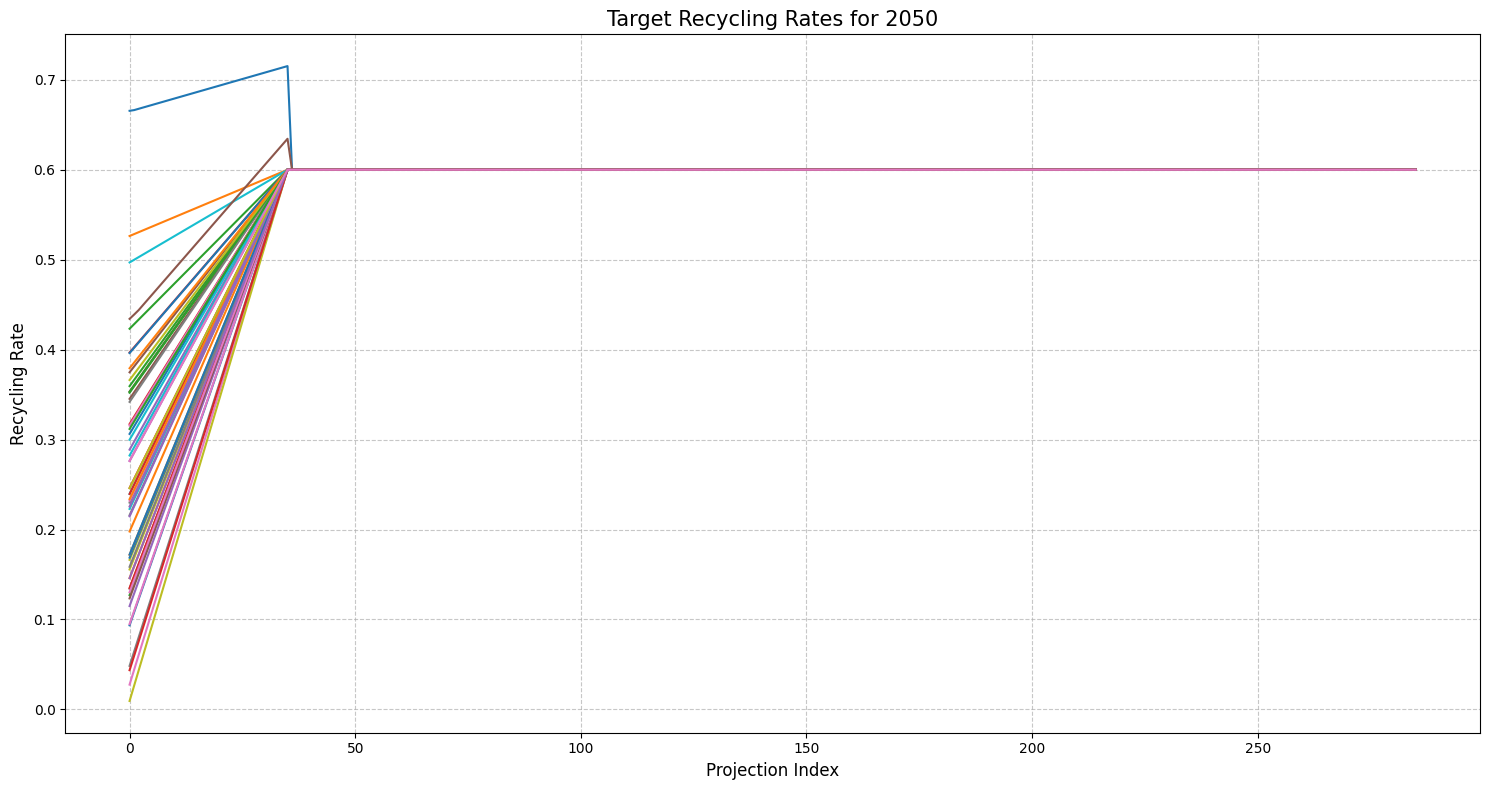

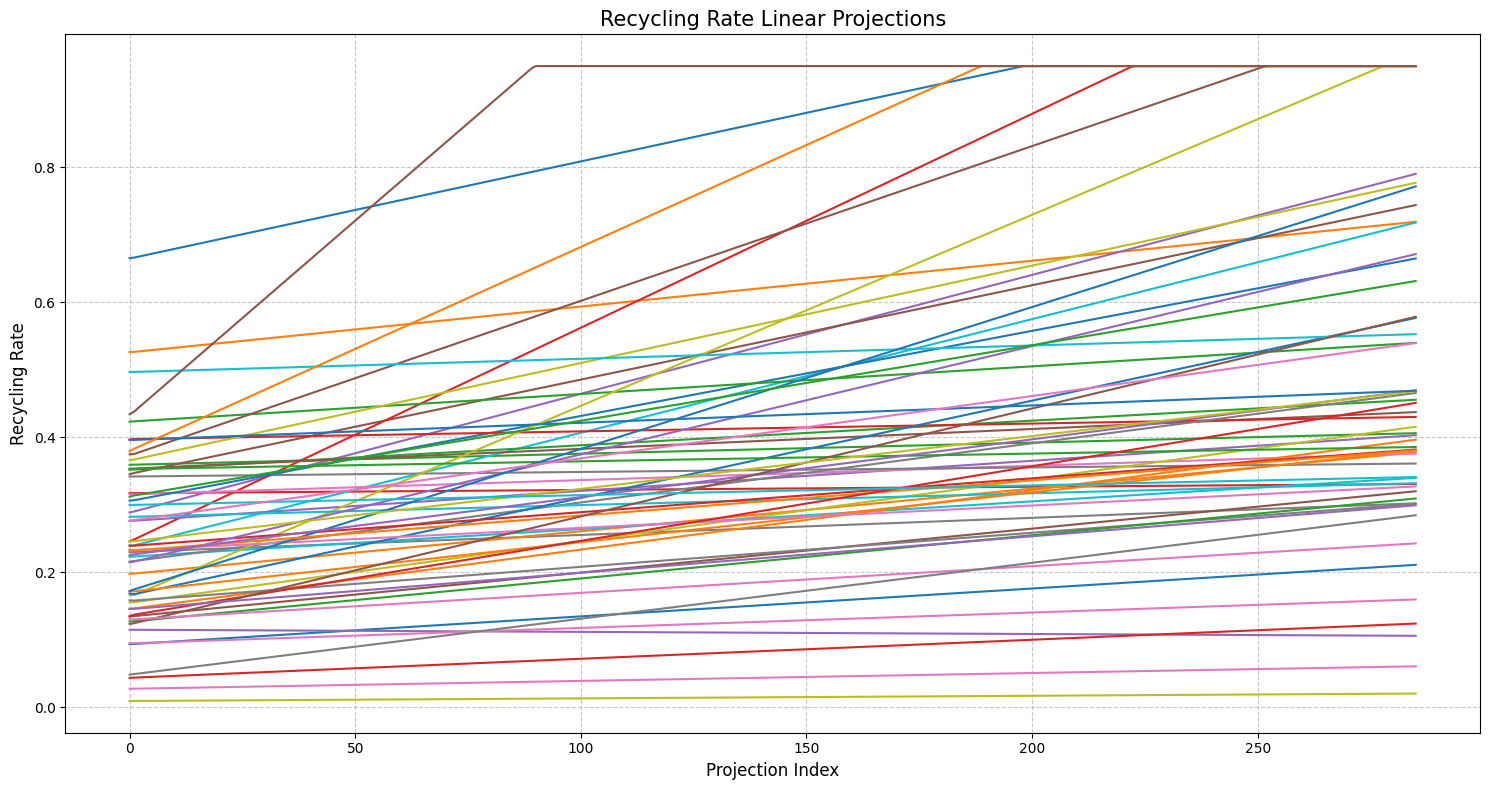

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Define the paths to your HDF5 files #TODO remove the shitty paths
file_path_2015 = r"C:\Users\angel\OneDrive\Escritorio\JUSTICE\JUSTICE\data\input\recycling_rates_arrays\recycling_rate_2015.hdf5"
file_path_2050 = r"C:\Users\angel\OneDrive\Escritorio\JUSTICE\JUSTICE\data\input\recycling_rates_arrays\recycling_rate_2050_target.hdf5"
file_path_projections = r"C:\Users\angel\OneDrive\Escritorio\JUSTICE\JUSTICE\data\input\recycling_rates_arrays\recycling_rate_linear_proyection.hdf5"

# Read the datasets from the HDF5 files
with h5py.File(file_path_2015, 'r') as f:
    recycling_rate_2015 = f['recycling_rate_2015'][:]

with h5py.File(file_path_2050, 'r') as f:
    recycling_rate_2050_target = f['recycling_rate_2050_target'][:]

with h5py.File(file_path_projections, 'r') as f:
    recycling_rate_linear_projections = f['recycling_rate_linear_proyection'][:]

# Plotting the target recycling rates for 2050
plt.figure(figsize=(15, 8))
for i in range(recycling_rate_2050_target.shape[0]):
    plt.plot(recycling_rate_2050_target[i], label=f'Region {i+1}')
plt.xlabel('Projection Index', fontsize=12)
plt.ylabel('Recycling Rate', fontsize=12)
plt.title('Target Recycling Rates for 2050', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting the linear projections
plt.figure(figsize=(15, 8))
for i in range(recycling_rate_linear_projections.shape[0]):
    plt.plot(recycling_rate_linear_projections[i], label=f'Region {i+1}')
plt.xlabel('Projection Index', fontsize=12)
plt.ylabel('Recycling Rate', fontsize=12)
plt.title('Recycling Rate Linear Projections', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Emissions Control Rate

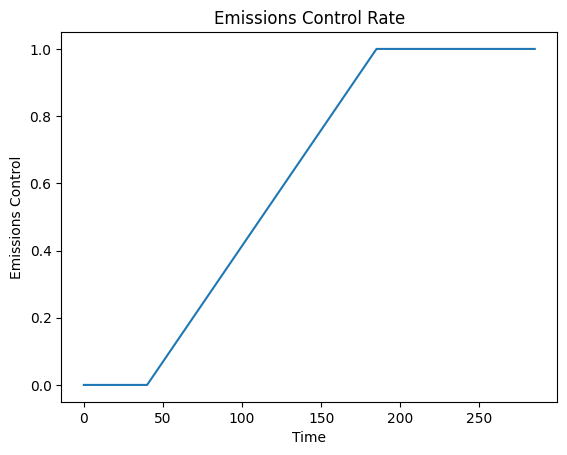

In [3]:
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.0 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 1.0
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

## Initialize model, select Scenario

In [4]:
# Get list of Scenarios from Enum

for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)

0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


In [5]:
from src.model import JUSTICE
from src.util.enumerations import Economy, DamageFunction, Abatement, WelfareFunction, EconomySubModules

# Instantiate the model
scenarios = 0
model = JUSTICE(
    scenario=scenarios,
    economy_type=Economy.NEOCLASSICAL,
    damage_function_type=DamageFunction.KALKUHL,
    abatement_type=Abatement.ENERDATA,
    social_welfare_function=WelfareFunction.UTILITARIAN,
    matter=EconomySubModules.MATTER,  # Specify the economy submodule as MATTER
)

c:\Users\angel\OneDrive\Escritorio\JUSTICE\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated


## Stepwise Run & Evaluate

In [6]:
# Run the model
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
for timestep in range(len(time_horizon.model_time_horizon)):
    model.stepwise_run(
        emission_control_rate=emissions_control_rate[:, timestep], 
        timestep=timestep, 
        endogenous_savings_rate=True, 
        recycling_rate=recycling_rate_linear_projections
    )
    datasets = model.stepwise_evaluate(timestep=timestep)

Extracting the data from the outcome dictionary to the different variables

In [7]:
#Load the data
depletion = datasets['depletion_ratio']#(57, 286, 1001)
emissions_avoided =datasets['emissions_avoided']#(57, 286, 1001)
dmc = datasets['material_consumption']#(57, 286, 1001)
recycled = datasets['recycled_material']#(57, 286, 1001)
extracted = datasets['extracted_matter']#(57, 286, 1001)
waste = datasets['waste']#(57, 286, 1001)
discard = datasets['discarded_material']#(57, 286, 1001)
reserves = datasets['material_reserves']#(57, 286, 1001)
resources = datasets['material_resources']#(57, 286, 1001)
r_costs= datasets['recycling_cost']#(57, 286, 1001)

gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
disentangled_utility = datasets['disentangled_utility'] #(57, 286, 1001)
welfare = datasets['welfare'] # (1001,)
welfare_temporal = datasets['welfare_temporal']  # (286, 1001)
welfare_regional = datasets['welfare_regional'] # (57, 1001)
welfare_regional_temporal = datasets['welfare_regional_temporal'] # (57, 286, 1001)


## Visualize

We can visualize the timeseries of the different outcomes that we extracted in the previous step

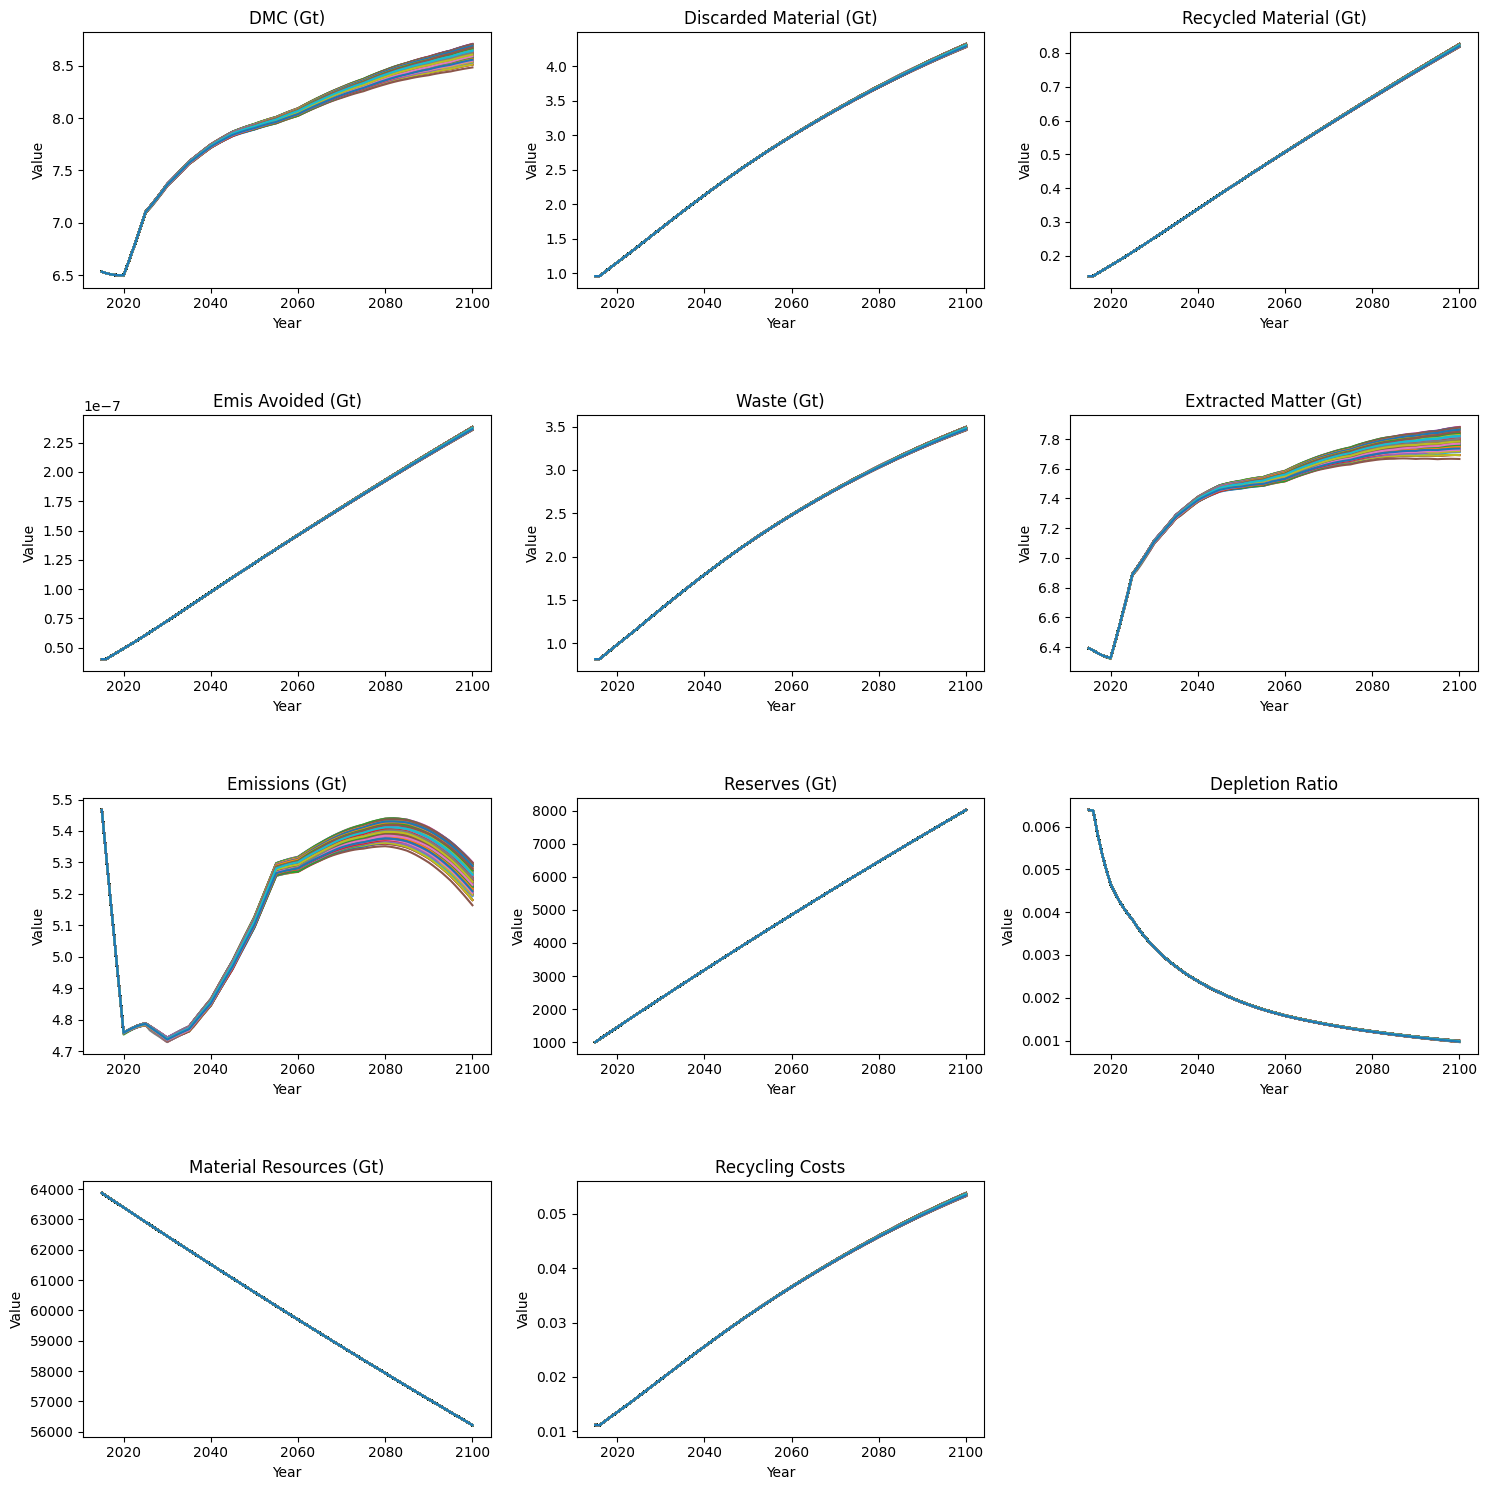

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create list of all the data arrays
data_list = [dmc, discard, recycled,
 emissions_avoided, waste, extracted, emis_control, reserves,
 depletion, resources, r_costs
 ]
titles = ['DMC (Gt)', 'Discarded Material (Gt)',
    'Recycled Material (Gt)', 'Emis Avoided (Gt)', 'Waste (Gt)',
    'Extracted Matter (Gt)', 'Emissions (Gt)','Reserves (Gt)', 'Depletion Ratio',
    'Material Resources (Gt)', 'Recycling Costs'
]

region_index = 54
# Number of steps to plot
num_steps = 86

# Slice the time horizon to the first 86 steps
time_horizon_sliced = time_horizon.model_time_horizon[:num_steps]

# Create a figure with 4 rows and 3 columns
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, loaded_data in enumerate(data_list):
    # Select the region based on region_index
    region_data = loaded_data[region_index, :, :]
    
    # Limit to the first 86 steps
    region_data_sliced = region_data[:num_steps, :]
    
    # Create a line plot for each scenario
    for j in range(region_data_sliced.shape[1]):
        sns.lineplot(x=time_horizon_sliced, y=region_data_sliced[:, j], ax=axs[i])
    
    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')

# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.show()


In [ ]:
from src.util.visualizer import plot_timeseries

fig = plot_timeseries(

    path_to_data="data/reevaluation",
    path_to_output="./data/plots/regional",
    x_label="Years",
    y_label="Temperature Rise (°C)",
    variable_name="global_temperature",
    input_data=[#"UTIL_100049.pkl", 
                #"EGAL_101948.pkl", 
                #"PRIOR_101765.pkl", 
                "SUFF_102924.pkl",
                ],
    output_titles=[#"Utilitarian", 
                   #"Egalitarian", 
                   #"Prioritarian", 
                   "Sufficientarian"],
    main_title="Global Temperature Rise - ",
    show_title=False,
    saving=True,
    yaxis_lower_limit=0,
    yaxis_upper_limit=10,
    alpha=0.1,
    linewidth=2.5,
    start_year=2015,
    end_year=2300,
    visualization_start_year=2025,
    visualization_end_year=2300,
    scenario_list= ['SSP119',  'SSP245',  'SSP370', 'SSP434', 'SSP585'] #['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585'],

)

# fig.show()

## Run all the Scenarios

In [7]:
from src.model import JUSTICE
from src.util.enumerations import Economy, DamageFunction, Abatement, WelfareFunction, EconomySubModules

# Create a dictionary to store the data for each scenario
scenario_data = {}
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

# List of scenarios to run
scenario_list = ['SSP119', 'SSP245', 'SSP370', 'SSP434', 'SSP585']

# Filter scenarios
filtered_scenarios = [s for s in Scenario.__members__.keys() if s in scenario_list]

for idx, scenario_name in enumerate(filtered_scenarios):
    print(idx, scenario_name)
    
    # Initialize the model
    model = JUSTICE(
            scenario=idx,
            economy_type=Economy.NEOCLASSICAL,
            damage_function_type=DamageFunction.KALKUHL,
            abatement_type=Abatement.ENERDATA,
            social_welfare_function=WelfareFunction.UTILITARIAN,
            matter=EconomySubModules.MATTER,
        )
    for timestep in range(len(time_horizon.model_time_horizon)):
        model.stepwise_run(
            emission_control_rate=emissions_control_rate[:, timestep], 
            timestep=timestep, 
            endogenous_savings_rate=True, 
            recycling_rate=recycling_rate_linear_projections
        )
        
        scenario_data[scenario_name] = model.stepwise_evaluate(timestep=timestep)



0 SSP119
Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated
1 SSP245
Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated
2 SSP370
Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated
3 SSP434
Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated
4 SSP585
Kalkuhl Damage Function Activated
Enerdata Abatement Model Activated
Neoclassical Economy Model Activated
Matter Model Activated


In [24]:
#Extract variables of interest
emissions_avoided_data = {}

for scenario_name, data in scenario_data.items():
    # Assuming data["emissions_avoided"] has shape (regions, timesteps, ensembles)
    emissions_avoided = datasets['emissions_avoided']
    emissions_avoided_data[scenario_name] = emissions_avoided

In [31]:
#Aggregate data for visualization

def aggregate_emissions_avoided(emissions_avoided_data):
    aggregated_data = {}
    for scenario_name, emissions_avoided in emissions_avoided_data.items():
        # Average over regions (axis 0) and ensembles (axis 2)
        mean_values = emissions_avoided.mean(axis=(0, 2))  # Shape: (timesteps,)
        std_dev = emissions_avoided.std(axis=(0, 2))  # Standard deviation for uncertainty
        aggregated_data[scenario_name] = (mean_values, std_dev)
    return aggregated_data
# Example usage:
# emissions_avoided_data = { ... }  # Your loaded data
aggregated_data = aggregate_emissions_avoided(emissions_avoided_data)

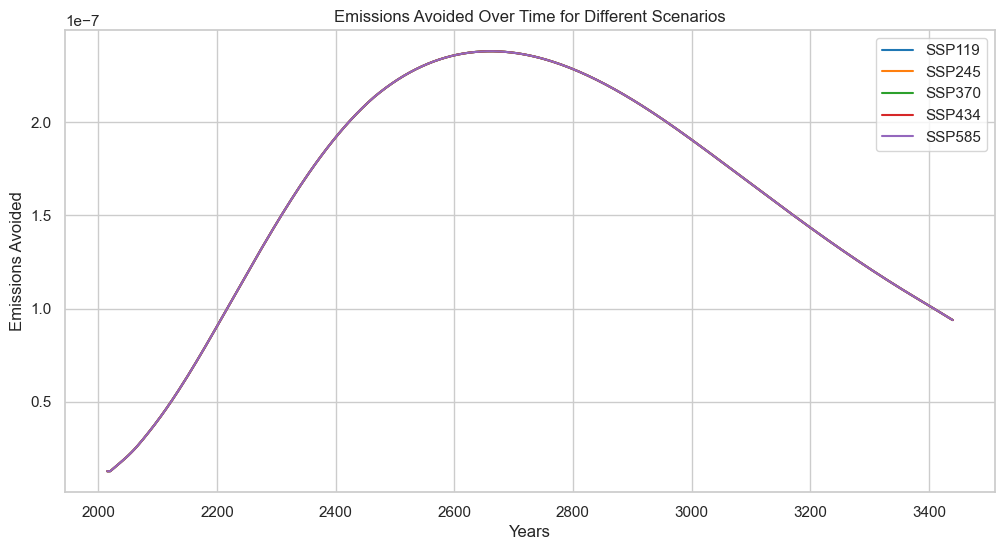

In [32]:
def plot_simple_timeseries(
    aggregated_data,
    start_year=2015,
    end_year=2300,
    data_timestep=5,
    x_label="Years",
    y_label="Emissions Avoided",
    main_title="Emissions Avoided Over Time for Different Scenarios",
    figsize=(12, 6)
):
    # Calculate the years based on start_year and data_timestep
    timesteps = next(iter(aggregated_data.values()))[0].shape[0]  # Extracting shape from mean_values
    years = np.arange(start_year, start_year + timesteps * data_timestep, data_timestep)

    # Create the plot
    plt.figure(figsize=figsize)
    
    for scenario_name, (mean_values, std_dev) in aggregated_data.items():
        plt.plot(years, mean_values, label=scenario_name)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(main_title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_simple_timeseries(
    aggregated_data,
    start_year=2015,
    end_year=2300,
    data_timestep=5
)
